In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
1,714 cases (7 day average) as of Tue 18 May, +54.6 since Mon 17 May
76 hospitalised (7 day average) as of Wed 19 May, +0.0 since Wed 19 May
4 died (7 day average) as of Tue 18 May, -1.3 since Mon 17 May


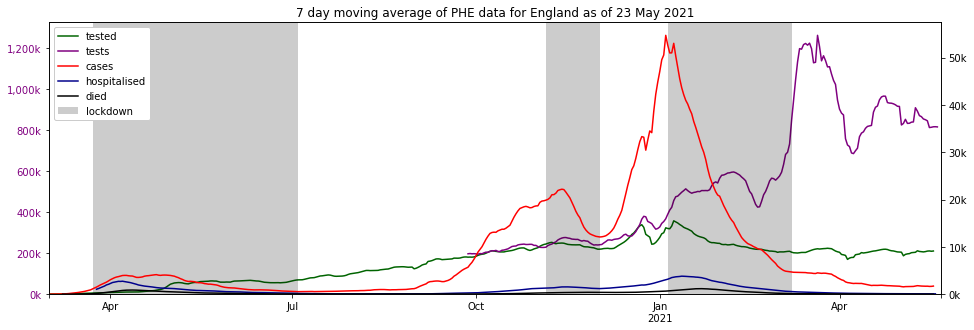

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

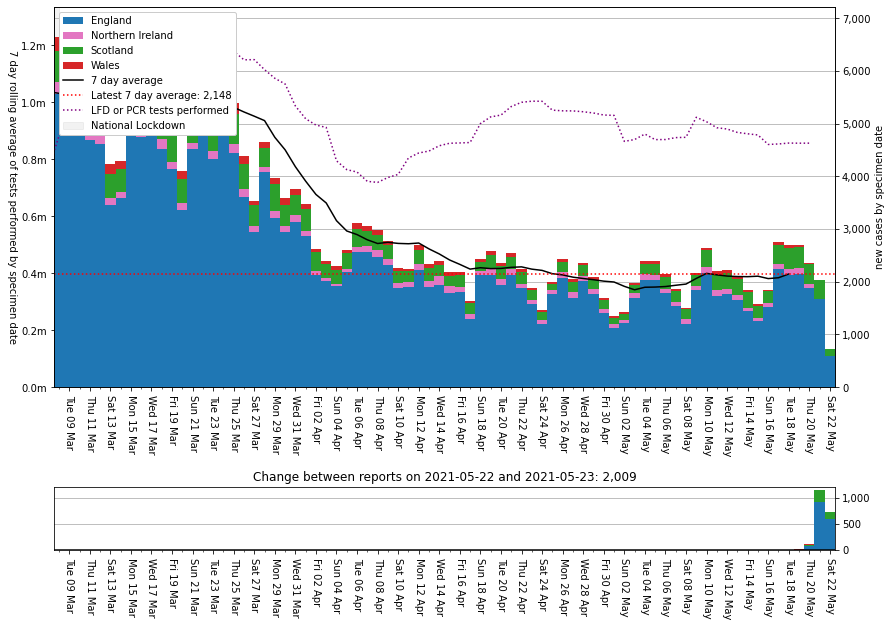

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

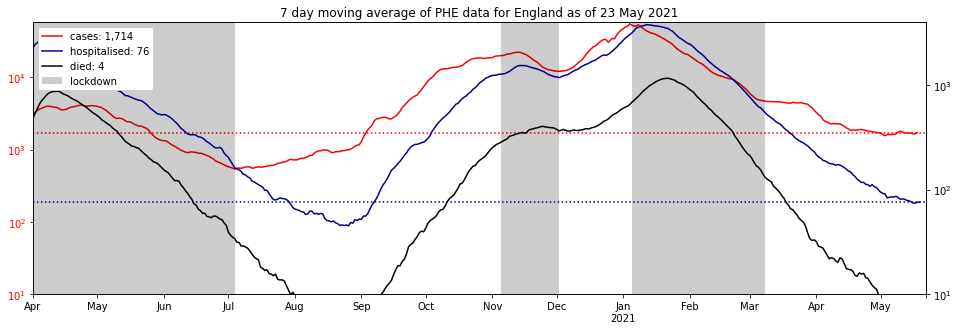

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

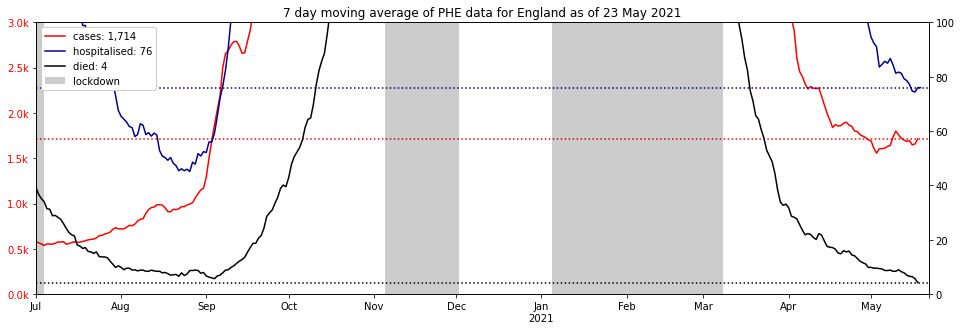

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=3_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=100)

In [7]:
vaccination_changes()

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,19207569.0,31725097.0,12517528.0,56286961,34.124367,22.238770,43.636863
1,Northern Ireland,N92000002,606212.0,1017941.0,411729.0,1893667,32.012598,21.742418,46.244984
2,Scotland,S92000003,1828930.0,3108819.0,1279889.0,5463300,33.476653,23.427031,43.096315
3,Wales,W92000004,1000706.0,2091824.0,1091118.0,3152879,31.739436,34.607037,33.653527


'partial: 37,943,681 (56.8%), full: 22,643,417'

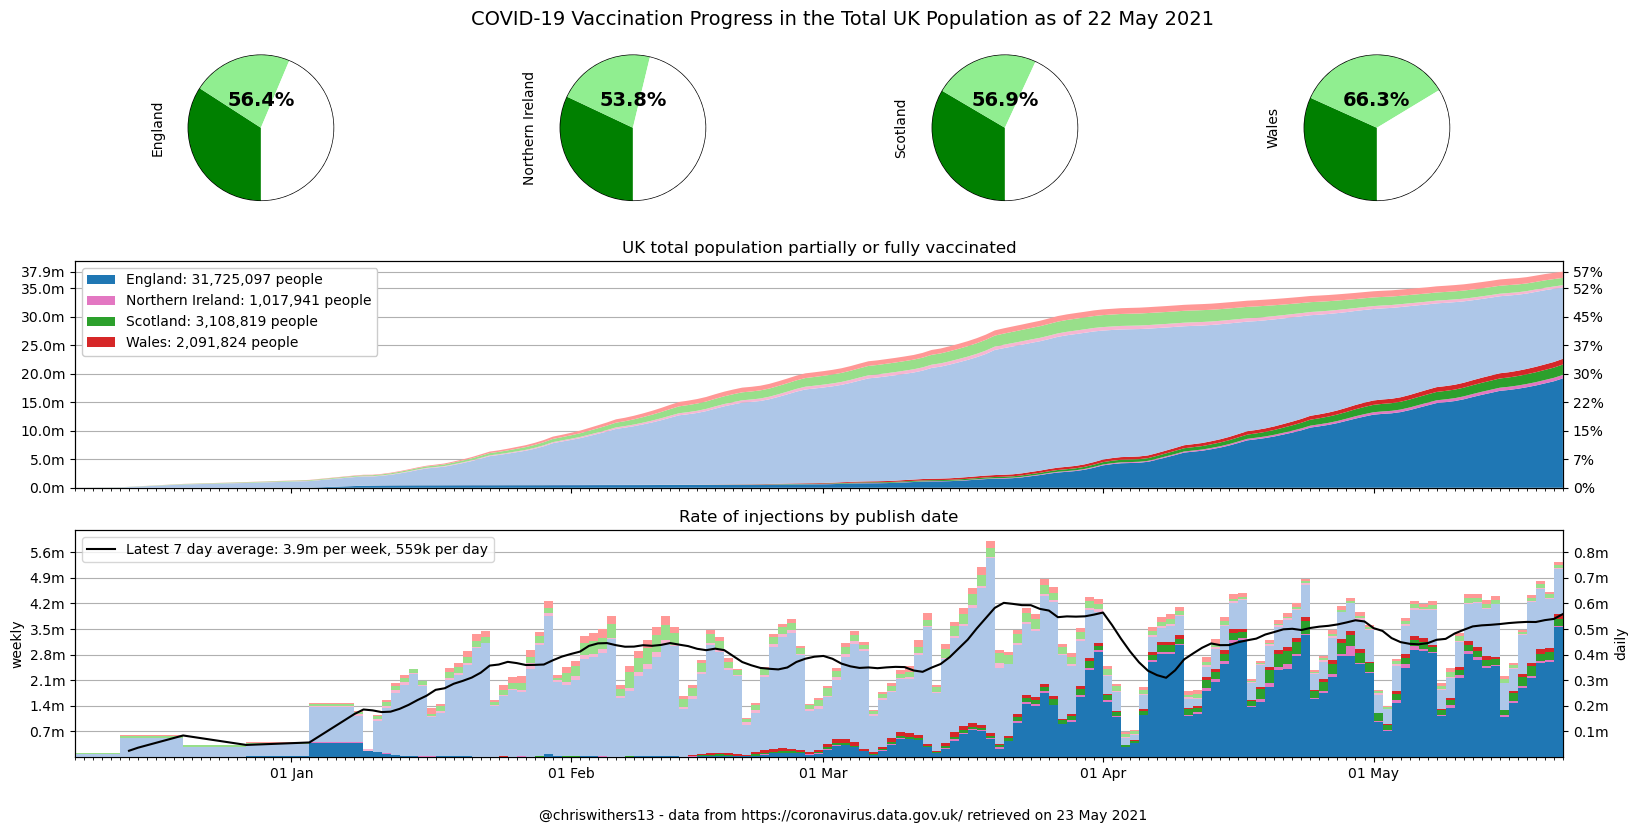

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

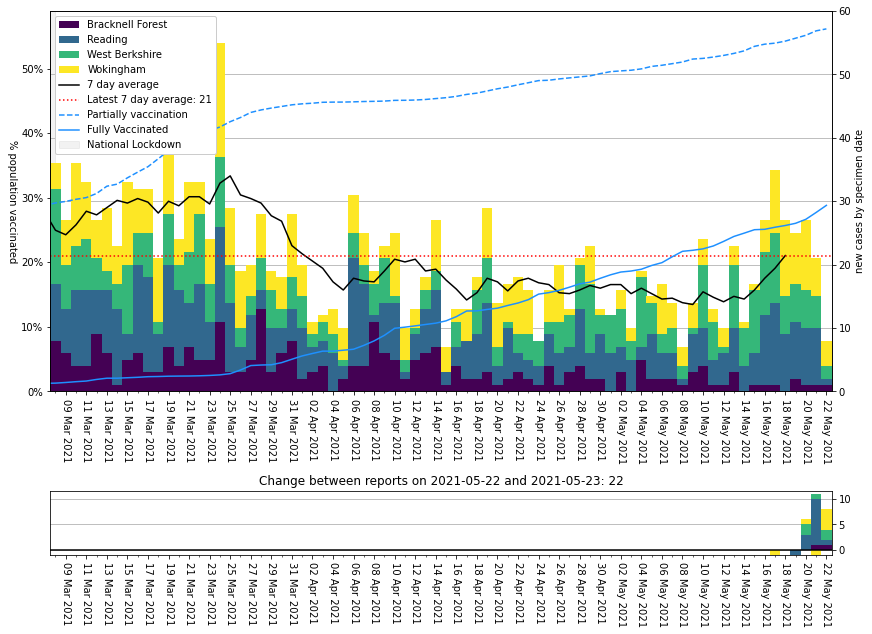

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], ylim=60,  lines=population_vaccinated)

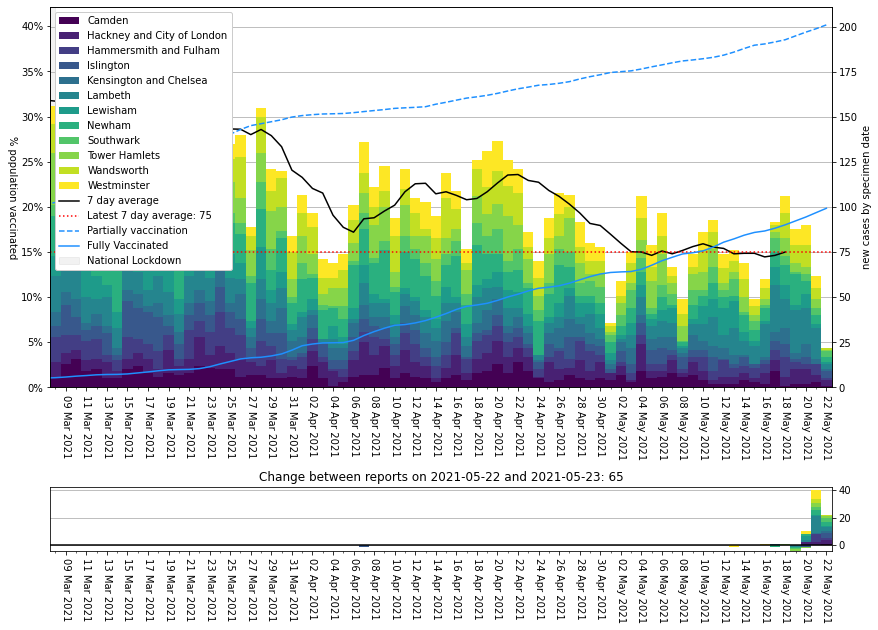

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,419.057555,1205.0,2021-05-22
E06000008,Blackburn with Darwen,287.248824,430.0,2021-05-22
E06000055,Bedford,183.505297,318.0,2021-05-22
S12000005,Clackmannanshire,145.518044,75.0,2021-05-22
S12000049,Glasgow City,130.622947,827.0,2021-05-22
E07000125,Rossendale,121.708962,87.0,2021-05-22
E08000034,Kirklees,99.821050,439.0,2021-05-22
S12000011,East Renfrewshire,99.445200,95.0,2021-05-22
S12000019,Midlothian,76.789963,71.0,2021-05-22


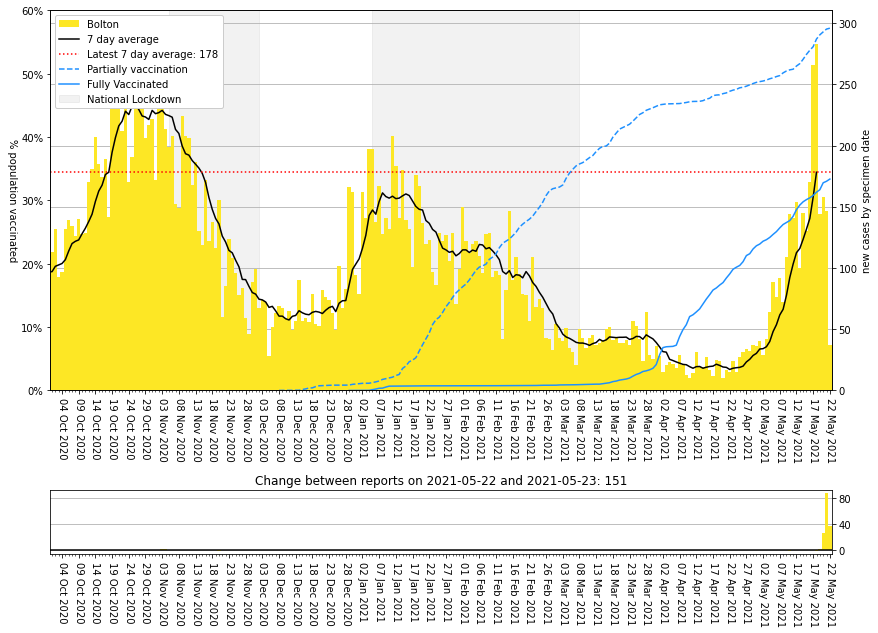

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=population_vaccinated)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,419.057555,1205.0,2021-05-22
S12000049,Glasgow City,130.622947,827.0,2021-05-22
E08000034,Kirklees,99.821050,439.0,2021-05-22
E06000008,Blackburn with Darwen,287.248824,430.0,2021-05-22
E08000003,Manchester,61.317734,339.0,2021-05-22
E06000055,Bedford,183.505297,318.0,2021-05-22
E08000035,Leeds,36.311416,288.0,2021-05-22
E08000032,Bradford,50.391273,272.0,2021-05-22
E08000025,Birmingham,21.281888,243.0,2021-05-22


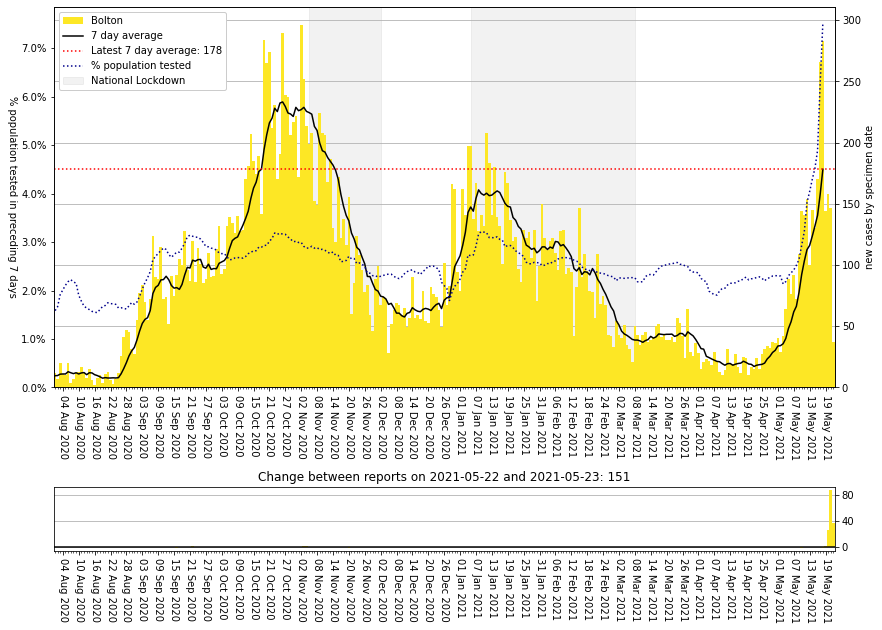

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested, earliest='2020-08')

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.6
phe_max = 0.25

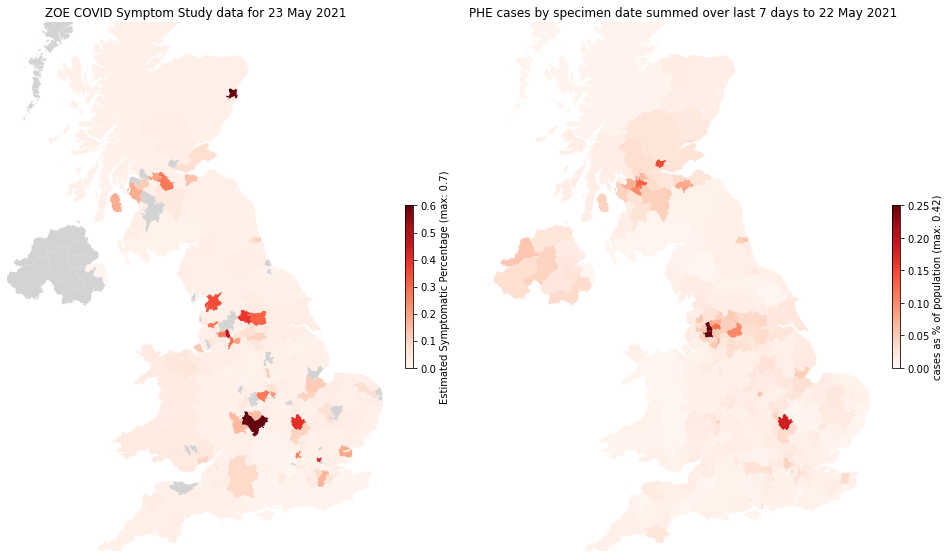

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...